# Lagged Association of Relative Humidity with Excess Death Rates during the Covid-19 Pandemic in the United States.

In [1]:
import pandas as pd,statsmodels,sklearn,numpy,extractors,importlib
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
importlib.reload(extractors)
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import scipy.stats

installsNeeded=False

utils = importr('utils')
base = importr('base')

if (installsNeeded):
    packages=['stats','lmtest','plm','sandwich','Hmisc','MASS','spdep']
    for pkg in packages:
        utils.install_packages(pkg)
        
plm=importr('plm')
stats=importr('stats')
lmtest=importr('lmtest')
sandwich=importr('sandwich')
Hmisc=importr('Hmisc')
MASS=importr('MASS')


In [2]:
print(robjects.r('version'))

               _                           

platform       x86_64-w64-mingw32          

arch           x86_64                      

os             mingw32                     

system         x86_64, mingw32             

status                                     

major          3                           

minor          6.1                         

year           2019                        

month          07                          

day            05                          

svn rev        76782                       

language       R                           

version.string R version 3.6.1 (2019-07-05)

nickname       Action of the Toes          



In [82]:
panelDF=pd.read_csv('panelDataFrame.csv')

def monthObj(monthAndYear):
    splts=monthAndYear.split('_')
    month=int(splts[1].strip())
    year=int(splts[0].strip())
    return datetime.date(year,month,1)

panelDF['MonthAndYearObj']=panelDF['MonthAndYear'].apply(monthObj)

#panelDF['DistanceFromJanuary']=panelDF['']

In [83]:
importlib.reload(extractors)

def doPlot(stateLevelDataToPlot,xVar,yVar,xlabel,ylabel,title,removeDenseNortheast=False,removeSD=False):
    fig, ax = plt.subplots()

    corr=stateLevelDataToPlot[[xVar,yVar]].corr()[xVar][1]
    R2=corr*corr
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.scatter(stateLevelDataToPlot[xVar],stateLevelDataToPlot[yVar] )

    #abbrs=[extractors.abbrevDict[v] for v in stateLevelDataToPlot['State/Territory'].values ]
    #for i in range(stateLevelDataToPlot.shape[0]):
    #    ax.annotate(abbrs[i], (stateLevelDataToPlot[inEq].values[i], stateLevelDataToPlot[deathMetric].values[i]))
    fig.savefig('ExcessVsHumidityDeviation2MonthsPrev.png',format='png')#,bbox_inches='tight')

Plotting excess death percentage vs. deviation from the state's median RH 2 months previously reveals that very high excess pct almost never occurs when RH for the state is unusually high 2 months previously and very low excess pct almost never occurs when RH is unusually low 2 months previously. Obviously, a great many factors influence excess death rates during the pandemic, which is probably why there is little observable pattern for intermediate RH values, but the pattern at the extremes is quite clear.  

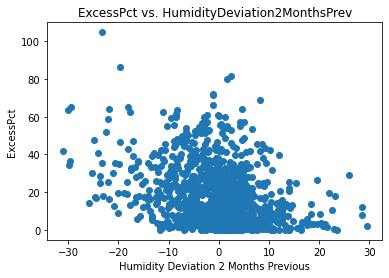

In [84]:
doPlot(panelDF,'HumidityDeviation2MonthsPrev',
       'ExcessPctCurrent','Humidity Deviation 2 Months Previous','ExcessPct','ExcessPct vs. HumidityDeviation2MonthsPrev') 

In [85]:
panelDFToUse=panelDF


def runSimpleAssociation(panelDFToUse,humidityLevel='HumidityDeviation2MonthsPrev',excessThresh=30,humidityThresh=10):
   
    belowAvg=panelDFToUse[panelDFToUse[humidityLevel] < -humidityThresh]
    numHumidityBelow=belowAvg.shape[0]
    print('num state/month pairs with humidity at least %3.1f pct below median: %d'%(humidityThresh,numHumidityBelow))
    totalNumAboveExcess=panelDFToUse[panelDFToUse['ExcessPctCurrent'] > excessThresh].shape[0]
    
    aboveAvg=panelDFToUse[panelDFToUse[humidityLevel] > humidityThresh]
    numHumidityAbove=aboveAvg.shape[0]
    print('num state/month pairs with humidity at least %3.1f pct above median: %d'%(humidityThresh,numHumidityAbove))
    
    totalNumMonths=panelDFToUse.shape[0]
    
    print('total state/month pairs with excess above %3.1f pct: %d of %d, %3.1f pct'%(excessThresh,totalNumAboveExcess,totalNumMonths,100*totalNumAboveExcess/totalNumMonths))
    print(Hmisc.binconf(totalNumAboveExcess,totalNumMonths))
    numExcessAboveForHumidityAbove=aboveAvg[aboveAvg['ExcessPctCurrent'] > excessThresh].shape[0]
    numExcessAboveForHumidityBelow=belowAvg[belowAvg['ExcessPctCurrent'] > excessThresh].shape[0]
    print('num state/monthpairs with excess above %3.1f pct for humidity at least %3.1f pct below median: %d out of %d, %3.1f pct'%(excessThresh,humidityThresh,
                                                                                                                                numExcessAboveForHumidityBelow,numHumidityBelow,
                                                                                                                                100*numExcessAboveForHumidityBelow/numHumidityBelow))
        
    print(Hmisc.binconf(numExcessAboveForHumidityBelow,numHumidityBelow))
    print('num state/month pairs with excess above %3.1f pct for humidity at least %3.1f pct above median: %d out of %d, %3.1f pct'%(excessThresh,humidityThresh,
                                                                                                                                     numExcessAboveForHumidityAbove,numHumidityAbove,
                                                                                                                                     100*numExcessAboveForHumidityAbove/numHumidityAbove))
    print(Hmisc.binconf(numExcessAboveForHumidityAbove,numHumidityAbove))
                                                                                                                                     


    
    print('low humidity, high excess:')
    print('number of states represented among states with humidity at least %3.1f below median and excess above threshold: '%humidityThresh,len(list(set(belowAvg[belowAvg['ExcessPctCurrent'] > excessThresh]['State'].values))))
    print(belowAvg[belowAvg['ExcessPctCurrent'] > excessThresh].groupby(['State'])['State'].count())
    print('high humidity:')
    print('number of states represented among states with humidity at least %3.1f above median: '%humidityThresh,len(list(set(aboveAvg['State'].values))))
    print(aboveAvg.groupby(['State'])['State'].count())
#print(panelDF[panelDF['State']=='Maryland'][['MonthAndYear','ActualHumidity2MonthsPrev','HumidityDeviation2MonthsPrev','ExcessPct']])

Excess death above 30 percent is far more likely 2 months after a month with RH at least 10 percent below median than after a month with RH at least 10 percent above. 30 percent excess and 10 percent RH deviations are chosen to correpond roughly to 1 standard deviation of those variables, although the code can obviously be rerun with different thresholds chosen if so desired. 

In [86]:
runSimpleAssociation(panelDF,humidityLevel='HumidityDeviation2MonthsPrev')

num state/month pairs with humidity at least 10.0 pct below median: 109
num state/month pairs with humidity at least 10.0 pct above median: 80
total state/month pairs with excess above 30.0 pct: 216 of 1122, 19.3 pct
  PointEst     Lower     Upper

 0.1925134 0.1705079 0.2166171

num state/monthpairs with excess above 30.0 pct for humidity at least 10.0 pct below median: 42 out of 109, 38.5 pct
  PointEst     Lower     Upper

 0.3853211 0.2993459 0.4791043

num state/month pairs with excess above 30.0 pct for humidity at least 10.0 pct above median: 3 out of 80, 3.8 pct
 PointEst      Lower     Upper

   0.0375 0.01283457 0.1045472

low humidity, high excess:
number of states represented among states with humidity at least 10.0 below median and excess above threshold:  22
State
Arizona           1
Arkansas          1
California        1
Georgia           1
Idaho             4
Illinois          1
Iowa              1
Kentucky          1
Minnesota         1
Montana           6
Nebraska   

The pattern holds up even if we exclude winter months. 

In [64]:
panelDFNoWinter=panelDF.copy()

panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2020_11']
panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2020_12']
panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2021_1']
panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2021_2']

panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2021_11']
panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2021_12']
panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2022_1']
panelDFNoWinter=panelDFNoWinter[panelDFNoWinter['MonthAndYear'] != '2022_2']

runSimpleAssociation(panelDFNoWinter,'HumidityDeviation2MonthsPrev')

num state/month pairs with humidity at least 10.0 pct below median: 53
num state/month pairs with humidity at least 10.0 pct above median: 62
total state/month pairs with excess above 30.0 pct: 86 of 714, 12.0 pct
  PointEst      Lower     Upper

 0.1204482 0.09858255 0.1463761

num state/monthpairs with excess above 30.0 pct for humidity at least 10.0 pct below median: 19 out of 53, 35.8 pct
  PointEst     Lower     Upper

 0.3584906 0.2430195 0.4930886

num state/month pairs with excess above 30.0 pct for humidity at least 10.0 pct above median: 1 out of 62, 1.6 pct
   PointEst        Lower     Upper

 0.01612903 0.0008273112 0.0858672

low humidity, high excess:
number of states represented among states with humidity at least 10.0 below median and excess above threshold:  8
State
Arizona         1
Idaho           2
Montana         4
North_Dakota    1
Oregon          3
Utah            2
Washington      1
Wyoming         5
Name: State, dtype: int64
high humidity:
number of states repr

If we look at different lags (0 months, 1 month, 3 months), the strength of the association wanes in a way which is consistent with known lags between infection and death (2 to 8 weeks). 

In [65]:
runSimpleAssociation(panelDF,humidityLevel='HumidityDeviationCurrent')

num state/month pairs with humidity at least 10.0 pct below median: 115
num state/month pairs with humidity at least 10.0 pct above median: 94
total state/month pairs with excess above 30.0 pct: 217 of 1122, 19.3 pct
  PointEst     Lower     Upper

 0.1934046 0.1713558 0.2175457

num state/monthpairs with excess above 30.0 pct for humidity at least 10.0 pct below median: 24 out of 115, 20.9 pct
  PointEst     Lower     Upper

 0.2086957 0.1444454 0.2917783

num state/month pairs with excess above 30.0 pct for humidity at least 10.0 pct above median: 13 out of 94, 13.8 pct
  PointEst      Lower     Upper

 0.1382979 0.08263778 0.2223603

low humidity, high excess:
number of states represented among states with humidity at least 10.0 below median and excess above threshold:  14
State
Arkansas         2
Connecticut      2
Idaho            1
Kansas           1
Massachusetts    1
Missouri         1
Montana          2
Oklahoma         3
Oregon           2
Rhode_Island     2
Texas            

In [33]:
runSimpleAssociation(panelDF,humidityLevel='HumidityDeviation1MonthsPrev')

num state/month pairs with humidity at least 10.0 pct below median: 114
num state/month pairs with humidity at least 10.0 pct above median: 82
total state/month pairs with excess above 30.0 pct: 217 of 1122, 19.3 pct
  PointEst     Lower     Upper

 0.1934046 0.1713558 0.2175457

num state/monthpairs with excess above 30.0 pct for humidity at least 10.0 pct below median: 34 out of 114, 29.8 pct
  PointEst     Lower     Upper

 0.2982456 0.2219614 0.3876837

num state/month pairs with excess above 30.0 pct for humidity at least 10.0 pct above median: 5 out of 82, 6.1 pct
   PointEst      Lower     Upper

 0.06097561 0.02632396 0.1349205

low humidity, high excess:
number of states represented among states with humidity at least 10.0 below median and excess above threshold:  19
State
Arizona         1
Arkansas        2
Idaho           3
Illinois        1
Iowa            1
Kansas          1
Minnesota       1
Montana         4
Nebraska        1
North_Dakota    2
Oklahoma        1
Oregon   

In [66]:
runSimpleAssociation(panelDF,humidityLevel='HumidityDeviation3MonthsPrev')

num state/month pairs with humidity at least 10.0 pct below median: 106
num state/month pairs with humidity at least 10.0 pct above median: 82
total state/month pairs with excess above 30.0 pct: 217 of 1122, 19.3 pct
  PointEst     Lower     Upper

 0.1934046 0.1713558 0.2175457

num state/monthpairs with excess above 30.0 pct for humidity at least 10.0 pct below median: 34 out of 106, 32.1 pct
  PointEst     Lower     Upper

 0.3207547 0.2395086 0.4145383

num state/month pairs with excess above 30.0 pct for humidity at least 10.0 pct above median: 4 out of 82, 4.9 pct
   PointEst      Lower     Upper

 0.04878049 0.01913107 0.1188146

low humidity, high excess:
number of states represented among states with humidity at least 10.0 below median and excess above threshold:  13
State
California      2
Idaho           4
Minnesota       2
Montana         6
Nevada          1
North_Dakota    2
Oregon          3
South_Dakota    1
Texas           2
Utah            3
Washington      1
Wisconsin

In addition to looking at associations of RH with high excess rates 2 months later, we can also look at associations with low excess rates 2 months later. The result below is not mentioned in the paper, for space considerations, but reinforces the pattern observed regarding high excess rates. A low excess rate (below 5 percent) is 5X more likely if RH is at least 10% above median than if at least 10% below.

In [35]:
def runForLowExcess(panelDFToUse,excessThresh=5,humidityLevel='HumidityDeviation2MonthsPrev',humidityThresh=10):
    aboveAvg=panelDFToUse[panelDFToUse[humidityLevel] > humidityThresh]
    numHumidityAbove=aboveAvg.shape[0]
    print('num state/month pairs with humidity at least %3.1f pct above median: %d'%(humidityThresh,numHumidityAbove))
    belowAvg=panelDFToUse[panelDFToUse[humidityLevel] < -humidityThresh]
    numHumidityBelow=belowAvg.shape[0]
    print('num state/month pairs with humidity at least %3.1f pct below median: %d'%(humidityThresh,numHumidityBelow))
    totalNumBelowExcess=panelDFToUse[panelDFToUse['ExcessPctCurrent'] < excessThresh].shape[0]
    totalNumMonths=panelDFToUse.shape[0]
    print('total state/month pairs with excess below %3.1f: %d of %d, %3.1f pct'%(excessThresh,totalNumBelowExcess,totalNumMonths,100*totalNumBelowExcess/totalNumMonths))
    print(Hmisc.binconf(totalNumBelowExcess,totalNumMonths))
    numExcessBelowForHumidityAbove=aboveAvg[aboveAvg['ExcessPctCurrent'] < excessThresh]['State'].shape[0]
    numExcessBelowForHumidityBelow=belowAvg[belowAvg['ExcessPctCurrent'] < excessThresh]['State'].shape[0]
    numStatesExcessBelowForHumidityAbove=len(set(aboveAvg[aboveAvg['ExcessPctCurrent'] < excessThresh]['State'].values))#,'MonthAndYear','HumidityDeviation2MonthsPrev']])
    print('num state/month pairs with excess below %3.1f pct for humidity at least %3.1f pct above median: %d out of %d, %3.1f pct'%(excessThresh,humidityThresh,
                                                                                                                                     numExcessBelowForHumidityAbove,
                                                                                                                                     numHumidityAbove,
                                                                                                                                     100*numExcessBelowForHumidityAbove/numHumidityAbove))  
    print('num distinct states: %d'%numStatesExcessBelowForHumidityAbove)
    print(Hmisc.binconf(numExcessBelowForHumidityAbove,numHumidityAbove))
    print('num state/monthpairs with excess below %3.1f pct for humidity at least %3.1f below median: %d out of %d, %3.1f pct'%(excessThresh,humidityThresh,
                                                                                                                                numExcessBelowForHumidityBelow,numHumidityBelow,
                                                                                                                                100*numExcessBelowForHumidityBelow/numHumidityBelow))
    print(Hmisc.binconf(numExcessBelowForHumidityBelow,numHumidityBelow))
    print(numExcessBelowForHumidityAbove,numExcessBelowForHumidityAbove/numHumidityAbove)
    print(numExcessBelowForHumidityBelow,numExcessBelowForHumidityBelow/numHumidityBelow)
    print('high humidity, low excess:')
    print(aboveAvg[aboveAvg['ExcessPctCurrent'] < excessThresh].groupby(['State'])['State'].count())
    print('low humidity:')
    print(belowAvg.groupby(['State'])['State'].count())
    

In [36]:
runForLowExcess(panelDF)

num state/month pairs with humidity at least 10.0 pct above median: 80
num state/month pairs with humidity at least 10.0 pct below median: 109
total state/month pairs with excess below 5.0: 242 of 1122, 21.6 pct
  PointEst     Lower     Upper

 0.2156863 0.1926117 0.2407011

num state/month pairs with excess below 5.0 pct for humidity at least 10.0 pct above median: 35 out of 80, 43.8 pct
num distinct states: 19
 PointEst     Lower     Upper

   0.4375 0.3341386 0.5465887

num state/monthpairs with excess below 5.0 pct for humidity at least 10.0 below median: 9 out of 109, 8.3 pct
   PointEst      Lower     Upper

 0.08256881 0.04404671 0.1495121

35 0.4375
9 0.08256880733944955
high humidity, low excess:
State
Arizona          1
California       2
Colorado         1
Connecticut      1
Idaho            3
Illinois         2
Indiana          1
Iowa             2
Michigan         1
Minnesota        2
Nebraska         2
Nevada           3
New_Hampshire    1
North_Dakota     3
Ohio         

We can inspect the timing of large spikes in excess death percentage vs. RH a few months prior for certain states to get some anecodotal evidence in addition to the various statistical measures in the paper.

In [39]:
def showExcessVsHumidity(state):
    print('\n\n' + state + '\n')
    stateDF=panelDF[panelDF['State']==state]
    print('mean humidity: %3.1f'%(stateDF['RelativeHumidity2MonthsPrev'].mean()))
    print('median humidity: %3.1f'%(stateDF['RelativeHumidity2MonthsPrev'].median()))
    print('stdev humidity: %3.1f'%(stateDF['RelativeHumidity2MonthsPrev'].std()))
    print('mean hist avg humidity: %3.1f'%(stateDF['HistoricalAvgRelativeHumidity2MonthsPrev'].mean()))
    print(stateDF[['MonthAndYear','ExcessPctCurrent','RelativeHumidity2MonthsPrev']])



In [67]:
#for state in sorted(list(set(panelDF['State'].values))):
#    print(state)
showExcessVsHumidity('South_Dakota')



South_Dakota

mean humidity: 63.9
median humidity: 65.8
stdev humidity: 10.8
mean hist avg humidity: 68.1
     MonthAndYear  ExcessPctCurrent  RelativeHumidity2MonthsPrev
20         2020_5          3.835840                         77.8
71         2020_6          6.238882                         63.1
122        2020_7          7.075658                         76.2
173        2020_8         17.211545                         66.1
224        2020_9         23.919090                         69.5
275       2020_10         39.888532                         58.3
326       2020_11        105.277379                         42.5
377       2020_12         46.980272                         58.3
428        2021_1         18.486553                         58.6
479        2021_2          5.106622                         68.8
530        2021_3          1.770133                         76.1
581        2021_4          3.085862                         83.5
632        2021_5          3.362510            

In [42]:
showExcessVsHumidity('Hawaii')



Hawaii

mean humidity: 73.5
median humidity: 73.0
stdev humidity: 2.5
mean hist avg humidity: 69.8
     MonthAndYear  ExcessPctCurrent  RelativeHumidity2MonthsPrev
13         2020_5          0.537779                         78.1
64         2020_6          3.148258                         72.8
115        2020_7          1.947707                         75.2
166        2020_8          4.679219                         73.4
217        2020_9          8.475806                         72.3
268       2020_10          4.660820                         71.7
319       2020_11          3.361189                         71.2
370       2020_12          0.530657                         73.8
421        2021_1          0.063463                         77.7
472        2021_2          4.685852                         73.1
523        2021_3          2.241905                         76.2
574        2021_4          3.284868                         73.6
625        2021_5          2.797943                   

In [44]:
showExcessVsHumidity('California')



California

mean humidity: 46.8
median humidity: 46.0
stdev humidity: 7.9
mean hist avg humidity: 57.9
     MonthAndYear  ExcessPctCurrent  RelativeHumidity2MonthsPrev
19         2020_5          4.699677                         60.9
70         2020_6          7.045578                         55.5
121        2020_7         20.271155                         47.9
172        2020_8         21.552696                         41.1
223        2020_9         11.770878                         47.2
274       2020_10          6.076864                         42.5
325       2020_11         15.011756                         33.7
376       2020_12         62.207803                         35.0
427        2021_1         81.555132                         48.4
478        2021_2         27.452598                         36.2
529        2021_3          7.066734                         50.3
580        2021_4          0.941874                         59.4
631        2021_5          2.734299               

In [45]:
showExcessVsHumidity('Virginia')



Virginia

mean humidity: 72.2
median humidity: 72.5
stdev humidity: 4.4
mean hist avg humidity: 67.2
     MonthAndYear  ExcessPctCurrent  RelativeHumidity2MonthsPrev
11         2020_5         12.796055                         74.7
62         2020_6          5.785838                         68.2
113        2020_7         10.735978                         77.2
164        2020_8         13.599607                         76.2
215        2020_9         12.529307                         71.7
266       2020_10         11.116840                         71.9
317       2020_11         15.107242                         74.6
368       2020_12         27.766815                         72.1
419        2021_1         36.678542                         73.3
470        2021_2         19.843777                         69.7
521        2021_3          4.404282                         73.0
572        2021_4          5.129939                         69.5
623        2021_5          5.693772                 

## Negative Binomial Regression

In [87]:
outcome='ExcessDeathCountCurrent'

predictors=['RelativeHumidity2MonthsPrev',
            'Stringency2MonthsPrev',
            'MaskMandates2MonthsPrev',
            'MobilityReduction2MonthsPrev',
            'CumulCasesPer330Mill3MonthsPrev',
            'DeviationFrom68Fahrenheit2MonthsPrev',
            'CovidDeathsPer330Mill2MonthsPrev',
            'FahrenheitTemperature2MonthsPrev',
            'BoostedRate2MonthsPrev',
            'VaxRate2MonthsPrev']

predictorsUsingMobilityResidual=[p.replace('MobilityReduction','MobilityResidual') for p in predictors]

predictorsStandardized=[p + '_stdized' for p in predictors]

modelString=outcome + '~' + "+".join(predictors)

modelStringStdized=outcome + '~' + "+".join(predictorsStandardized)


includeTimeFixedParams=True

timeDummyModelString=''

timeFixedParamPredictors=[]

When using dummy variables for a particular month, the dummy variable for one of the months is redundant, since that month is implied by all other month dummy variables taking a value of 0. The same logic applies for dummy variables for states. Here we arbitrarily choose May 2020 and Kansas to be removed from the dummy variable coding. One single month and and single state can be chosen without changing the regression results (this can be verified by rerunning the code if desired).

In [88]:
ARBITRARY_MONTH='2020_5'

modelStringPreFixedEffects=modelString

if (includeTimeFixedParams):
    for col in panelDF.columns:
        if (col.find('isMonthAndYear') != -1):
            if (col.find(ARBITRARY_MONTH)==-1):
                modelString=modelString + '+' + col
                timeFixedParamPredictors.append(col)
                #timeDummyModelString=timeDummyModelString + '+' + col

                
includeStateFixedParams=True

stateFixedParamPredictors=[]
stateDummyModelString=''

ARBITRARY_STATE='Kansas'

if (includeStateFixedParams):
    for col in panelDF.columns:
        if (col.find('isState') != -1):
            if (col.find(ARBITRARY_STATE)==-1):
                modelString=modelString + '+' + col
                stateFixedParamPredictors.append(col)
                #stateDummyModelString=stateDummyModelString + '+' + col
modelString=modelString.replace(outcome + '+',outcome)

fixedParamPredictors=stateFixedParamPredictors + timeFixedParamPredictors

Summary statistics for RH, controls and outcomes are presented here. 

In [89]:

summaryStatsDct=dict()

variables=predictors + ['ExcessPctCurrent','CovidDeathsPer330MillCurrent']

summaryStatsDct['Variable']=variables
summaryStatsDct['Mean']=numpy.array([panelDF[var].mean() for var in variables])
summaryStatsDct['Std']=numpy.array([panelDF[var].std() for var in variables])
summaryStatsDct['Max']=numpy.array([panelDF[var].max() for var in variables])
summaryStatsDct['Min']=numpy.array([panelDF[var].min() for var in variables])

summaryStatsDF=pd.DataFrame(summaryStatsDct)

print(summaryStatsDF)

                                Variable          Mean           Std  \
0            RelativeHumidity2MonthsPrev  6.757602e+01  1.448762e+01   
1                  Stringency2MonthsPrev  5.053789e+01  1.527324e+01   
2                MaskMandates2MonthsPrev  4.087666e-01  4.796146e-01   
3           MobilityReduction2MonthsPrev  8.517402e+00  1.205405e+01   
4        CumulCasesPer330Mill3MonthsPrev  2.074645e+07  1.753852e+07   
5   DeviationFrom68Fahrenheit2MonthsPrev  1.505080e+01  1.186065e+01   
6       CovidDeathsPer330Mill2MonthsPrev  3.494281e+04  3.616324e+04   
7       FahrenheitTemperature2MonthsPrev  5.936934e+01  1.711283e+01   
8                 BoostedRate2MonthsPrev  2.229487e+00  7.038534e+00   
9                     VaxRate2MonthsPrev  1.995024e+01  2.448068e+01   
10                      ExcessPctCurrent  1.772583e+01  1.554740e+01   
11          CovidDeathsPer330MillCurrent  3.830351e+04  3.388057e+04   

             Max        Min  
0   9.110000e+01  14.400000  
1  

In [90]:
import rpy2.robjects as robjects

type(panelDF)

from rpy2.robjects import vectors
from rpy2.robjects import pandas2ri
pandas2ri.activate()


panelDF_R = pandas2ri.py2ri(panelDF)

C:\Users\joe_s\Anaconda3\envs\renv\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "MonthAndYearObj". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'datetime.date'>'
  (name, str(e)))


Negative binomial regression is set up to predict counts but can be adapted to predict rates via the use of an offset. An offset is an independent variable whose coefficient is fixed at 1.  ExcessDeathPct = ExcessDeathCountCurrent/ExpectedDeathCountCurrent.  Therefore log(ExcessDeathPct)= log(ExcessDeathCountCurrent/ExpectedDeathCountCurrent)=log(ExcessDeathCountCurrent) - log(ExpectedDeathCountCurrent). If we think in terms of a regression model with log(ExcessDeathPct) ~ RH+ controls, equivalently, log(ExpectedDeathCountCurrent) can be moved to the right hand side and used as an independent variable with coefficient fixed at 1, with the regression now using log(ExcessDeathCountCurrent) as the dependent variable.  

In [91]:
addOffset=True

modelStringExcessPct=modelString + "+offset(log(ExpectedDeathCountCurrent))"
    
modelStringCovidDeathRate=modelStringExcessPct.replace('ExcessDeathCountCurrent','CovidDeathCountCurrent')
modelStringCovidDeathRate=modelStringCovidDeathRate.replace("+offset(log(ExpectedDeathCountCurrent))","+offset(log(StatePopulation))")
 

def stdize(mString):
    for pred in predictors:
        mString=mString.replace(pred,pred + '_stdized')
    return mString

modelStringExcessPctStdized=stdize(modelStringExcessPct)

modelStringCovidDeathRateStdized=stdize(modelString)

def runNegBinModel(mString,dFrame,stdErrs='clustered',popWeighted=False):
    if (popWeighted):
        negBinRes=MASS.glm_nb(mString,data=pandas2ri.py2ri(dFrame),weights=panelDF['StatePopulation'])
    else:
        negBinRes=MASS.glm_nb(mString,data=pandas2ri.py2ri(dFrame))

    #stdErrs='clustered'
    if (stdErrs=='standard'):
        negBinCoefTest=lmtest.coeftest(negBinRes)
    elif (stdErrs=='HC3'):
        negBinCoefTest=lmtest.coeftest(negBinRes,vcov=sandwich.vcovHC(negBinRes,type="HC3"))
    elif (stdErrs=='clustered'):
        negBinCoefTest=lmtest.coeftest(negBinRes,vcov=sandwich.vcovCL(negBinRes,cluster=dFrame["State"].values))
    return negBinCoefTest,negBinRes

In [96]:
negBinModelExcessPctCoef,result=runNegBinModel(modelStringExcessPct,panelDF)

Before we examine the model coefficients, let's confirm that we understand the mechanics of the model by reproducing the fitted values. Here are first 10 fitted values:

In [97]:
print(result.rx('fitted.values')[0][0:10])

 [1]  528.7834  687.1867 1393.9247  307.8330  277.9730  612.5774  569.0481

 [8]  309.0471 1330.4029  814.5487



The model prediction should be a product of the exponential of the coefficient times the corresponding variable, for all such variables and the intercept.

In [98]:
def predict(resultCoef,i,offsetName='ExpectedDeathCountCurrent'):
    def getCoef(coefName):
        #print(coefName)
        #print(coef.names)
        #print(coef[coef.names.index('Stringency2MonthsPrev')])
        return resultCoef[resultCoef.names.index(coefName)]
    product=numpy.exp(getCoef('(Intercept)'))*panelDF[offsetName].values[i]
    
    allPredictors=predictors + fixedParamPredictors
    for pred in allPredictors:
        product=product*numpy.exp(getCoef(pred)*panelDF[pred].values[i])
    return product

recreatedPredictions=numpy.array([predict(result.rx('coefficients')[0],i) for i in range(panelDF.shape[0])])
print(recreatedPredictions[0:10])



ValueError: list.index(x): x not in list

Here are the results of the primary regression model presented in the paper (excess death pct vs. RH with various controls).

In [99]:
print(negBinModelExcessPctCoef)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           1.6256e+00  8.5980e-01   1.8907 0.0586703

RelativeHumidity2MonthsPrev          -2.0096e-02  3.7361e-03  -5.3790 7.491e-08

StringencyLast2Months                -2.2702e-03  3.5203e-03  -0.6449 0.5189989

MaskMandates2MonthsPrev              -3.5617e-01  8.3469e-02  -4.2671 1.980e-05

MobilityReduction2MonthsPrev         -2.5558e-02  1.0499e-02  -2.4344 0.0149150

CumulCasesPer330Mill3MonthsPrev      -7.3502e-08  8.5258e-09  -8.6212 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev -3.6925e-03  5.5231e-03  -0.6685 0.5037855

CovidDeathsPer330Mill2MonthsPrev     -3.5433e-06  8.3487e-07  -4.2442 2.194e-05

FahrenheitTemperature2MonthsPrev     -3.0373e-02  6.2423e-03  -4.8656 1.141e-06

BoostedRate2MonthsPrev               -1.1866e-02  9.6559e-03  -1.2289 0.2191156

VaxRate2MonthsPrev                   -4.4701e-02  8.0309e-03  -5.5661 2.605e-08


We need to write some code to look at 95% CIs for the coefficients themselves and also for the multiplicative association with excess percentage itself rather than the log itself. 

In [33]:
def getVal(coefTest,coefName,j):
    lst=str(coefTest).split('z test of coefficients')[1].split(coefName)[1].split('\n')[0].split(' ')
    nonEmpty=[]
    for l in lst:
        if (l.strip() != ''):
            nonEmpty.append(l.strip())
    return float(nonEmpty[j])

def getEstimate(coefTest,coefName):
    return getVal(coefTest,coefName,0)

def getStdError(coefTest,coefName):
    return getVal(coefTest,coefName,1)

def showMultiplicativeAssociationAndCI(coefTest,coef,delta=-1,stdev=True,unitStrDict=dict()):
    #print('coef',coef)
    est=getEstimate(coefTest,coef)
    stdErr=getStdError(coefTest,coef)
    multEst=numpy.exp(est*delta)
    if (est > 0):
        multCILow=numpy.exp((est+ 1.96*stdErr)*delta)
        multCIHigh=numpy.exp((est - 1.96*stdErr)*delta)
        ciLow=est -1.96*stdErr
        ciHigh=est + 1.96*stdErr
    else:
        multCILow=numpy.exp((est - 1.96*stdErr)*delta)
        multCIHigh=numpy.exp((est + 1.96*stdErr)*delta) 
        ciLow=est + 1.96*stdErr
        ciHigh=est - 1.96*stdErr
    unitStr=unitStrDict.get(coef,'')
    if (stdev):
        unitStr='stdev'
    print('multiplicative estimate: %4.4f [%4.4f, %4.4f] per %d %s'%(multEst,multCILow,multCIHigh,delta,unitStr))
    #print('log-linear estimate: %9.9f [%9.9f, %9.9f] per 1 %s'%(est,ciLow,ciHigh,unitStr))
    print('log-linear estimate: ' +  "{:e}".format(est) + " [{:e},".format(ciLow) + " {:e}]".format(ciHigh) + " per 1 %s'"%(unitStr))

deltas={"RelativeHumidity2MonthsPrev":10,
        "HistoricalAvgHumidity2MonthsPrev":10,
        "Stringency2MonthsPrev":10,
       "MobilityReduction2MonthsPrev":10,
       "CumulCasesPer330Mill3MonthsPrev":1e6,
       "VaxRate2MonthsPrev":10,
       "BoostedRate2MonthsPrev":10,
       "FahrenheitTemperature2MonthsPrev":10,
        'DeviationFrom68Fahrenheit2MonthsPrev':10,
       "CovidDeathsPer330Mill2MonthsPrev":1e4}


unitStrDct={"RelativeHumidity2MonthsPrev":'RH percent',
            "HistoricalAvgHumidity2MonthsPrev":"RH percent",
        "Stringency2MonthsPrev":'Oxford Stringency Index units',
       "MobilityReduction2MonthsPrev":'Mobility reduction percent',
       "CumulCasesPer330Mill3MonthsPrev":'cumulative cases per 330 million people',
       "VaxRate2MonthsPrev":'vaccination rate percent',
       "BoostedRate2MonthsPrev":'boosted rate percent',
       "FahrenheitTemperature2MonthsPrev":'degree Fahrenheit',
        'DeviationFrom68Fahrenheit2MonthsPrev':'degrees Fahrenheit abs difference from 68F (room temp)',
       "CovidDeathsPer330Mill2MonthsPrev":'covid death 2 months previous'}



In [34]:
for p in predictors:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelExcessPctCoef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')
    

RelativeHumidity2MonthsPrev
multiplicative estimate: 0.8421 [0.7810, 0.9079] per 10 RH percent
log-linear estimate: -1.719100e-02 [-9.658328e-03, -2.472367e-02] per 1 RH percent'



Stringency2MonthsPrev
multiplicative estimate: 0.9441 [0.8394, 1.0620] per 10 Oxford Stringency Index units
log-linear estimate: -5.749500e-03 [6.012852e-03, -1.751185e-02] per 1 Oxford Stringency Index units'



MaskMandates2MonthsPrev
multiplicative estimate: 0.6974 [0.5921, 0.8215] per 1 
log-linear estimate: -3.603900e-01 [-1.966575e-01, -5.241225e-01] per 1 '



MobilityReduction2MonthsPrev
multiplicative estimate: 0.7768 [0.6329, 0.9534] per 10 Mobility reduction percent
log-linear estimate: -2.525900e-02 [-4.771120e-03, -4.574688e-02] per 1 Mobility reduction percent'



CumulCasesPer330Mill3MonthsPrev
multiplicative estimate: 0.9290 [0.9141, 0.9442] per 1000000 cumulative cases per 330 million people
log-linear estimate: -7.362700e-08 [-5.739918e-08, -8.985482e-08] per 1 cumulative cases per 330 mil

Results are similar when using covid death rates rather than all-cause excess death rates.

In [35]:
negBinModelCovidDeathRateCoef,_=runNegBinModel(modelStringCovidDeathRate,panelDF)
print(negBinModelCovidDeathRateCoef)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                          -6.0523e+00  4.6897e-01 -12.9056 < 2.2e-16

RelativeHumidity2MonthsPrev          -1.5872e-02  2.8258e-03  -5.6169 1.944e-08

Stringency2MonthsPrev                -6.2424e-03  4.1640e-03  -1.4991 0.1338385

MaskMandates2MonthsPrev              -2.8688e-01  7.9742e-02  -3.5977 0.0003211

MobilityReduction2MonthsPrev         -2.9003e-02  1.0452e-02  -2.7749 0.0055213

CumulCasesPer330Mill3MonthsPrev      -6.5839e-08  7.0136e-09  -9.3874 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev  8.2335e-03  4.1744e-03   1.9724 0.0485648

CovidDeathsPer330Mill2MonthsPrev      1.5806e-06  8.8160e-07   1.7929 0.0729914

FahrenheitTemperature2MonthsPrev     -3.3153e-02  5.7796e-03  -5.7362 9.680e-09

BoostedRate2MonthsPrev               -4.4788e-03  7.2271e-03  -0.6197 0.5354353

VaxRate2MonthsPrev                   -4.9578e-02  6.5347e-03  -7.5869 3.276e-14


In [36]:
for p in predictors:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelCovidDeathRateCoef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

RelativeHumidity2MonthsPrev
multiplicative estimate: 0.8532 [0.8073, 0.9018] per 10 RH percent
log-linear estimate: -1.587200e-02 [-1.033343e-02, -2.141057e-02] per 1 RH percent'



Stringency2MonthsPrev
multiplicative estimate: 0.9395 [0.8659, 1.0194] per 10 Oxford Stringency Index units
log-linear estimate: -6.242400e-03 [1.919040e-03, -1.440384e-02] per 1 Oxford Stringency Index units'



MaskMandates2MonthsPrev
multiplicative estimate: 0.7506 [0.6420, 0.8776] per 1 
log-linear estimate: -2.868800e-01 [-1.305857e-01, -4.431743e-01] per 1 '



MobilityReduction2MonthsPrev
multiplicative estimate: 0.7482 [0.6096, 0.9184] per 10 Mobility reduction percent
log-linear estimate: -2.900300e-02 [-8.517080e-03, -4.948892e-02] per 1 Mobility reduction percent'



CumulCasesPer330Mill3MonthsPrev
multiplicative estimate: 0.9363 [0.9235, 0.9492] per 1000000 cumulative cases per 330 million people
log-linear estimate: -6.583900e-08 [-5.209234e-08, -7.958566e-08] per 1 cumulative cases per 330 mil

Results are similar if the long-term historical average monthly RH for each state, obtained from ncei.noaa.gov, is used. While it may seem surprising that the coefficient is slightly larger when using historical average is used rather than actual RH over the course of the pandemic is used, note that the confidence interval is significantly wider when using the historical average. 

In [37]:
negBinModelUsingHistoricalAvgHumidityCoef,_=runNegBinModel(modelStringExcessPct.replace('RelativeHumidity','HistoricalAvgHumidity'),panelDF)
print(negBinModelUsingHistoricalAvgHumidityCoef)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           9.7247e-01  7.5794e-01   1.2830 0.1994771

HistoricalAvgHumidity2MonthsPrev     -2.1462e-02  5.1682e-03  -4.1526 3.287e-05

Stringency2MonthsPrev                -3.9257e-03  5.9901e-03  -0.6554 0.5122355

MaskMandates2MonthsPrev              -3.8190e-01  8.4257e-02  -4.5326 5.826e-06

MobilityReduction2MonthsPrev         -2.5838e-02  1.0936e-02  -2.3627 0.0181416

CumulCasesPer330Mill3MonthsPrev      -7.5451e-08  8.7180e-09  -8.6546 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev -1.3716e-03  5.4235e-03  -0.2529 0.8003423

CovidDeathsPer330Mill2MonthsPrev     -3.2235e-06  7.7242e-07  -4.1733 3.003e-05

FahrenheitTemperature2MonthsPrev     -2.0684e-02  6.0228e-03  -3.4343 0.0005942

BoostedRate2MonthsPrev               -6.7253e-03  1.0175e-02  -0.6609 0.5086514

VaxRate2MonthsPrev                   -4.7441e-02  8.0473e-03  -5.8953 3.741e-09


In [68]:
for p in predictors:
    if (p=='RelativeHumidity2MonthsPrev'):
        pToUse="HistoricalAvgHumidity2MonthsPrev"
    else:
        pToUse=p
    print(pToUse)
    showMultiplicativeAssociationAndCI(negBinModelUsingHistoricalAvgHumidityCoef,pToUse,delta=deltas.get(pToUse,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

HistoricalAvgHumidity2MonthsPrev
multiplicative estimate: 0.8068 [0.7291, 0.8929] per 10 RH percent
log-linear estimate: -2.146200e-02 [-1.133233e-02, -3.159167e-02] per 1 RH percent'



Stringency2MonthsPrev
multiplicative estimate: 0.9615 [0.8550, 1.0813] per 10 Oxford Stringency Index units
log-linear estimate: -3.925700e-03 [7.814896e-03, -1.566630e-02] per 1 Oxford Stringency Index units'



MaskMandates2MonthsPrev
multiplicative estimate: 0.6826 [0.5787, 0.8051] per 1 
log-linear estimate: -3.819000e-01 [-2.167563e-01, -5.470437e-01] per 1 '



MobilityReduction2MonthsPrev
multiplicative estimate: 0.7723 [0.6233, 0.9569] per 10 Mobility reduction percent
log-linear estimate: -2.583800e-02 [-4.403440e-03, -4.727256e-02] per 1 Mobility reduction percent'



CumulCasesPer330Mill3MonthsPrev
multiplicative estimate: 0.9273 [0.9116, 0.9433] per 1000000 cumulative cases per 330 million people
log-linear estimate: -7.545100e-08 [-5.836372e-08, -9.253828e-08] per 1 cumulative cases per 33

The RH coefficient is similar if we restrict data to state-month pairs either above or below national median RH. 

In [ ]:
medianHumidity=panelDF['RelativeHumidity2MonthsPrev'].median()
print('median RH: %3.1f'%(medianHumidity))


In [ ]:
panelDFAboveMedianHumidity=panelDF[panelDF['RelativeHumidity2MonthsPrev'] >= medianHumidity]
negBinModelAboveMedianHumidityCoef,_=runNegBinModel(modelStringExcessPct,panelDFAboveMedianHumidity)
print(negBinModelAboveMedianHumidityCoef)

In [ ]:
for p in predictors:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelAboveMedianHumidityCoef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

In [ ]:
panelDFBelowMedianHumidity=panelDF[panelDF['RelativeHumidity2MonthsPrev'] < medianHumidity]
negBinModelBelowMedianHumidityCoef,_=runNegBinModel(modelStringExcessPct,panelDFBelowMedianHumidity)
print(negBinModelBelowMedianHumidityCoef)

In [ ]:
for p in predictors:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelBelowMedianHumidityCoef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

Results are robust to the removal of any 2 states from the regression, with only modest changes in the coefficient for RH. 

In [76]:
primaryVariableStudied='RelativeHumidity2MonthsPrev'
    
import gc

estimatesForTwoStatesRemoved=[]
stdErrsForTwoStatesRemoved=[]
states=list(set(panelDF['State'].values))

cnt=0

doRemoveStates=True

numStates=len(states)

if (doRemoveStates):
    for i1 in range(numStates):
        for i2 in range(i1+1,numStates):
            state=states[i1]
            state2=states[i2]
            #if (state2 ==state):
            #    continue
            #print(state,
            cnt=cnt +1
            if (cnt%100==0):
                print(cnt)
            panelDFStatesRemoved=panelDF[numpy.logical_and(panelDF['State'] != state,panelDF['State'] != state2)].copy()
            #print(len(list(set(panelDFStateRemoved['State'].values))))
            panelDF_R_StatesRemoved = pandas2ri.py2ri(panelDFStatesRemoved)
            modelStringHere=modelStringExcessPct
            modelStringHere=modelStringHere.replace('+isState_' + state,'')
            modelStringHere=modelStringHere.replace('+isState_' + state2,'')
            #print(state,state2)
            #print(modelStringHere + '\n\n')
            negBinResStatesRemoved=MASS.glm_nb(modelStringHere,data=panelDF_R_StatesRemoved)
            negBinCoefTestStatesRemoved=lmtest.coeftest(negBinResStatesRemoved,vcov=sandwich.vcovCL(negBinResStatesRemoved,cluster=panelDFStatesRemoved["State"].values))
            estimatesForTwoStatesRemoved.append(getEstimate(negBinCoefTestStatesRemoved,primaryVariableStudied))
            stdErrsForTwoStatesRemoved.append(getStdError(negBinCoefTestStatesRemoved,primaryVariableStudied))
            del panelDFStatesRemoved
            del panelDF_R_StatesRemoved
            gc.collect()

    estimatesForTwoStatesRemoved=numpy.array(estimatesForTwoStatesRemoved)
    stdErrsForTwoStatesRemoved=numpy.array(stdErrsForTwoStatesRemoved)
    ciLower95Pct=estimatesForTwoStatesRemoved - 1.96*stdErrsForTwoStatesRemoved
    ciUpper95Pct=estimatesForTwoStatesRemoved + 1.96*stdErrsForTwoStatesRemoved
    print(primaryVariableStudied + ":\n")
    print('max estimate',numpy.max(estimatesForTwoStatesRemoved))
    print('min estimate',numpy.min(estimatesForTwoStatesRemoved))
    print('max stderr',numpy.max(stdErrsForTwoStatesRemoved))
    print('min stderr',numpy.min(stdErrsForTwoStatesRemoved))
    print('max lower bound 95% CI',numpy.max(ciLower95Pct))
    print('min lower bound 95% CI',numpy.min(ciLower95Pct))
    print('max upper bound 95% CI',numpy.max(ciUpper95Pct))
    print('min upper bound 95% CI',numpy.min(ciUpper95Pct))

100
200
300
400
500
600
700
800
900
1000
1100
1200
RelativeHumidity2MonthsPrev:

max estimate -0.018489
min estimate -0.022581
max stderr 0.0039658
min stderr 0.0034237
max lower bound 95% CI -0.025240452
min lower bound 95% CI -0.029530848
max upper bound 95% CI -0.011147720000000002
min upper bound 95% CI -0.01568376


Examining the regression coefficients when all independent variables are standardized to have 0 mean and variance 1 can be helpful when interpreting the relative magnitude of the various coefficients. Note that this model is fully equivalent to the non-standardized model already presented.

In [27]:
negBinModelExcessPctCoefStdized,_=runNegBinModel(modelStringExcessPctStdized,panelDF)
print(negBinModelExcessPctCoefStdized)



z test of coefficients:



                                               Estimate Std. Error  z value

(Intercept)                                  -4.8515679  0.2876158 -16.8682

RelativeHumidity2MonthsPrev_stdized          -0.2937698  0.0532002  -5.5220

Stringency2MonthsPrev_stdized                -0.0987696  0.0908250  -1.0875

MaskMandates2MonthsPrev_stdized              -0.1662523  0.0403104  -4.1243

MobilityReduction2MonthsPrev_stdized         -0.3027406  0.1257730  -2.4070

CumulCasesPer330Mill3MonthsPrev_stdized      -1.2880216  0.1484199  -8.6782

DeviationFrom68Fahrenheit2MonthsPrev_stdized -0.0441735  0.0650076  -0.6795

CovidDeathsPer330Mill2MonthsPrev_stdized     -0.1288289  0.0298612  -4.3143

FahrenheitTemperature2MonthsPrev_stdized     -0.5176079  0.1060007  -4.8831

BoostedRate2MonthsPrev_stdized               -0.0897001  0.0684982  -1.3095

VaxRate2MonthsPrev_stdized                   -1.1085693  0.1935693  -5.7270

isMonthAndYear_2020_10                        1

In [28]:
for p in [pl + '_stdized' for pl in  predictors]:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelExcessPctCoefStdized,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

RelativeHumidity2MonthsPrev_stdized
multiplicative estimate: 0.7454 [0.6716, 0.8274] per 1 
log-linear estimate: -0.293769800 [-0.189497408, -0.398042192] per 1 
log-linear estimate: -2.937698e-01 [-1.894974e-01, -3.980422e-01] per 1 '



Stringency2MonthsPrev_stdized
multiplicative estimate: 0.9060 [0.7582, 1.0825] per 1 
log-linear estimate: -0.098769600 [0.079247400, -0.276786600] per 1 
log-linear estimate: -9.876960e-02 [7.924740e-02, -2.767866e-01] per 1 '



MaskMandates2MonthsPrev_stdized
multiplicative estimate: 0.8468 [0.7825, 0.9165] per 1 
log-linear estimate: -0.166252300 [-0.087243916, -0.245260684] per 1 
log-linear estimate: -1.662523e-01 [-8.724392e-02, -2.452607e-01] per 1 '



MobilityReduction2MonthsPrev_stdized
multiplicative estimate: 0.7388 [0.5774, 0.9453] per 1 
log-linear estimate: -0.302740600 [-0.056225520, -0.549255680] per 1 
log-linear estimate: -3.027406e-01 [-5.622552e-02, -5.492557e-01] per 1 '



CumulCasesPer330Mill3MonthsPrev_stdized
multiplicative 

This paper is intended to examine the association of RH with excess deaths, but it may be tempting for readers to draw conclusions about some of the controls in the regression.  The set of appropriate controls for RH may not be the appropriate control set for another variable. In particular, the stringency index control is almost surely mediated by the Google Mobility data, so the insignificance of the stringency index should be interpreted with caution. In "Stringency of containment and closures on the growth of SARS-CoV-2 in Canada prior to accelerated vaccine roll-out" by Vickers, Baral, Mishra et. al (https://www.ijidonline.com/article/S1201-9712(22)00108-4/fulltext), which studies NPIs such as the stringency index, the mobility variable is regressed against stringency index and the residual of that regression is used as a control. Here we present the results of the same approach. 

In [39]:
modelStringExcessPctMobilityResidual=modelStringExcessPct.replace('Reduction','Residual')
negBinModelExcessPctMobilityResidual,_=runNegBinModel(modelStringExcessPctMobilityResidual,panelDF)
print(negBinModelExcessPctMobilityResidual)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           2.0534e+00  8.1140e-01   2.5307 0.0113832

RelativeHumidity2MonthsPrev          -2.0277e-02  3.6721e-03  -5.5220 3.352e-08

Stringency2MonthsPrev                -1.9022e-02  7.7889e-03  -2.4422 0.0145997

MaskMandates2MonthsPrev              -3.4664e-01  8.4047e-02  -4.1243 3.719e-05

MobilityResidual2MonthsPrev          -2.5115e-02  1.0434e-02  -2.4070 0.0160825

CumulCasesPer330Mill3MonthsPrev      -7.3440e-08  8.4625e-09  -8.6782 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev -3.7244e-03  5.4809e-03  -0.6795 0.4968128

CovidDeathsPer330Mill2MonthsPrev     -3.5624e-06  8.2573e-07  -4.3143 1.601e-05

FahrenheitTemperature2MonthsPrev     -3.0247e-02  6.1942e-03  -4.8831 1.045e-06

BoostedRate2MonthsPrev               -1.2744e-02  9.7319e-03  -1.3095 0.1903566

VaxRate2MonthsPrev                   -4.5283e-02  7.9070e-03  -5.7270 1.022e-08


C:\Users\joe_s\Anaconda3\envs\renv\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "MonthAndYearObj". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'datetime.date'>'
  (name, str(e)))


In [33]:
predictorsHere=[p.replace('Reduction','Residual') for p in predictors]

for p in predictorsHere:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelExcessPctMobilityResidual,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

RelativeHumidity2MonthsPrev
multiplicative estimate: 0.8165 [0.7598, 0.8774] per 10 RH percentage
log-linear estimate: -0.020277000 [-0.013079684, -0.027474316] per 1 RH percentage
log-linear estimate: -2.027700e-02 [-1.307968e-02, -2.747432e-02] per 1 RH percentage'



Stringency2MonthsPrev
multiplicative estimate: 0.8268 [0.7097, 0.9631] per 10 Oxford Stringency Index units
log-linear estimate: -0.019022000 [-0.003755756, -0.034288244] per 1 Oxford Stringency Index units
log-linear estimate: -1.902200e-02 [-3.755756e-03, -3.428824e-02] per 1 Oxford Stringency Index units'



MaskMandates2MonthsPrev
multiplicative estimate: 0.7071 [0.5997, 0.8337] per 1 
log-linear estimate: -0.346640000 [-0.181907880, -0.511372120] per 1 
log-linear estimate: -3.466400e-01 [-1.819079e-01, -5.113721e-01] per 1 '



MobilityResidual2MonthsPrev
multiplicative estimate: 0.9752 [0.9555, 0.9953] per 1 
log-linear estimate: -0.025115000 [-0.004664360, -0.045565640] per 1 
log-linear estimate: -2.511500e-02 

It may be of interest to see the result when no controls are used and excess death pct is simply regressed vs. RH. Such an approach is obviously far more vulnerable to objections regarding confounding, but may still be worth examining.

In [34]:
modelStringExcessPctVsRHUnadjusted='ExcessDeathCountCurrent~offset(log(ExpectedDeathCountCurrent))+RelativeHumidity2MonthsPrev'
negBinModelExcessPctVsRHUnadjusted,_=runNegBinModel(modelStringExcessPctVsRHUnadjusted,panelDF)
print(negBinModelExcessPctVsRHUnadjusted)



z test of coefficients:



                              Estimate Std. Error z value  Pr(>|z|)    

(Intercept)                 -0.7071692  0.1577801  -4.482 7.395e-06 ***

RelativeHumidity2MonthsPrev -0.0155434  0.0025768  -6.032 1.619e-09 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1





In [71]:
for p in ['RelativeHumidity2MonthsPrev']:#predictors:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelExcessPctVsRHUnadjusted,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

RelativeHumidity2MonthsPrev
multiplicative estimate: 0.8560 [0.8139, 0.9004] per 10 RH percent
log-linear estimate: -1.554340e-02 [-1.049287e-02, -2.059393e-02] per 1 RH percent'





Here we examine how sensitive the result is to the choice of controls. It would obviously be highly inappropriate statistical methodology to search systematically over a large number of combinations of controls in search of a particular result. Such a seach is presented here only to make the point that even if one were to do so in search of the combination of controls which is most unfavorable to the conclusion that RH is significant, no combo would be found where the 95% CI contains the null (0). 

In [70]:
controls=list(predictors)
controls.remove(primaryVariableStudied)

totalNumControls=len(controls) + 2

numCombinations=numpy.power(2,totalNumControls)

estimatesForControlCombos=[]
stdErrsForControlCombos=[]

controlCombos=[]

doControlCombos=True

if (doControlCombos):
    rng=range(numCombinations)
    print('numCombinations tested',numCombinations)
else:
    rng=[]

    
for combination in range(numCombinations):
    if (combination%10==0):
        print('combination',combination)
        
    def reverse(strng):
        strngRev = [strng[i] for i in range(len(strng)-1, -1, -1)]
        return "".join(strngRev)
    
    combinationBinary=reverse(bin(combination)[2:])
    
    controlsUsedHere=[]
    def isIncluded(i):
        if (len(combinationBinary) <= i):
            return False
        return combinationBinary[i]=='1'
    
    includeTimeFixedEffect=False
    includeStateFixedEffect=False
    for i in range(totalNumControls):
        if (i==totalNumControls-1):
            if (isIncluded(i)):
                includeTimeFixedEffect=True
        elif (i==totalNumControls-2):
            if (isIncluded(i)):
                includeStateFixedEffect=True
        else:
            if (isIncluded(i)):
                controlsUsedHere.append(controls[i])
    
    predictorsHere=controlsUsedHere + [primaryVariableStudied]
    modelStringHere=outcome + '~' + "+".join(predictorsHere )
    
    if (includeTimeFixedEffect):
        modelStringHere=modelStringHere + '+' + '+'.join(timeFixedParamPredictors)
    if (includeStateFixedEffect):
        modelStringHere=modelStringHere + '+' + '+'.join(stateFixedParamPredictors)
    addOffset=True

    if (addOffset):
        if (modelStringHere.find('ExcessDeathCountCurrent') != -1):
            modelStringHere=modelStringHere + "+offset(log(ExpectedDeathCountCurrent))"
        else:
            modelStringHere=modelStringHere + "+offset(log(StatePopulation))"
            
    panelDF_R = pandas2ri.py2ri(panelDF)#[[outcome,'State','MonthAndYear','StatePopulation','ExpectedDeathCountCurrent'] + predictors + fixedEffectPredictors ])  
    negBinRes=MASS.glm_nb(modelStringHere,data=panelDF_R)
    negBinCoefTest=lmtest.coeftest(negBinRes,vcov=sandwich.vcovCL(negBinRes,cluster=panelDF["State"].values))  
    estimatesForControlCombos.append(getEstimate(negBinCoefTest,primaryVariableStudied))
    stdErrsForControlCombos.append(getStdError(negBinCoefTest,primaryVariableStudied))
    controlCombos.append(modelStringHere + "," + str(includeTimeFixedEffect) + "," + str(includeStateFixedEffect))
    del panelDF_R
    gc.collect()

if (doControlCombos):
    estimatesForControlCombos=numpy.array(estimatesForControlCombos)
    stdErrsForControlCombos=numpy.array(stdErrsForControlCombos)
    #print(estimatesForControlCombos)
    #print(stdErrsForControlCombos)
    
    ciLower95Pct=estimatesForControlCombos - 1.96*stdErrsForControlCombos
    ciUpper95Pct=estimatesForControlCombos + 1.96*stdErrsForControlCombos

#ratiosForControlCombos=numpy.divide(estimatesForControlCombos,stdErrsForControlCombos)
    print(primaryVariableStudied + ':\n')
    print('max estimate',numpy.max(estimatesForControlCombos))
    print('min estimate',numpy.min(estimatesForControlCombos))
    print('max stderr',numpy.max(stdErrsForControlCombos))
    print('min stderr',numpy.min(stdErrsForControlCombos))
    print('max lower bound 95% CI',numpy.max(ciLower95Pct))
    print('min lower bound 95% CI',numpy.min(ciLower95Pct))
    print('max upper bound 95% CI',numpy.max(ciUpper95Pct))
    print('min upper bound 95% CI',numpy.min(ciUpper95Pct))

numCombinations tested 2048
combination 0
combination 10
combination 20
combination 30
combination 40
combination 50
combination 60
combination 70
combination 80
combination 90
combination 100
combination 110
combination 120
combination 130
combination 140
combination 150
combination 160
combination 170
combination 180
combination 190
combination 200
combination 210
combination 220
combination 230
combination 240
combination 250
combination 260
combination 270
combination 280
combination 290
combination 300
combination 310
combination 320
combination 330
combination 340
combination 350
combination 360
combination 370
combination 380
combination 390
combination 400
combination 410
combination 420
combination 430
combination 440
combination 450
combination 460
combination 470
combination 480
combination 490
combination 500
combination 510
combination 520
combination 530
combination 540
combination 550
combination 560
combination 570
combination 580
combination 590
combination 600
combina

RH remains significant whether we use data from the first half or the second half of the pandemic, although the association is stronger in the first half (pre-vax) period. It is possible that vaccines have dampened the magnitude of the association.

In [75]:
import datetime
panelDFThroughMarch2021=panelDF[panelDF['MonthAndYearObj'] <= datetime.date(2021,3,1)]
negBinModelThroughMarch21Coef,_=runNegBinModel(modelStringExcessPct.replace('VaxRate2MonthsPrev','').replace("+BoostedRate2MonthsPrev",''),panelDFThroughMarch2021)
print(negBinModelThroughMarch21Coef)
print(panelDFThroughMarch2021.shape)



z test of coefficients:



                                        Estimate  Std. Error z value  Pr(>|z|)

(Intercept)                           3.2817e+00  8.7492e-01  3.7509 0.0001762

RelativeHumidity2MonthsPrev          -2.8817e-02  4.9458e-03 -5.8265 5.659e-09

Stringency2MonthsPrev                -8.2797e-03  7.8758e-03 -1.0513 0.2931263

MaskMandates2MonthsPrev              -3.7773e-01  1.4327e-01 -2.6364 0.0083783

MobilityReduction2MonthsPrev         -3.4812e-02  1.4005e-02 -2.4856 0.0129335

CumulCasesPer330Mill3MonthsPrev      -1.0727e-07  2.1770e-08 -4.9273 8.339e-07

DeviationFrom68Fahrenheit2MonthsPrev -9.8614e-03  6.7233e-03 -1.4668 0.1424421

CovidDeathsPer330Mill2MonthsPrev     -2.5926e-06  1.0842e-06 -2.3912 0.0167922

FahrenheitTemperature2MonthsPrev     -4.6537e-02  8.4882e-03 -5.4825 4.192e-08

isMonthAndYear_2020_10                1.7840e+00  2.9347e-01  6.0789 1.210e-09

isMonthAndYear_2020_11                2.2379e+00  2.5842e-01  8.6596 < 2.2e-16

isMonthAndY

In [ ]:
for p in predictors:
    if (p.find('Boosted') != -1):
        continue
    if (p.find('Vax') != -1):
        continue
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelThroughMarch21Coef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

In [ ]:
panelDFPostApril2021=panelDF[panelDF['MonthAndYearObj'] > datetime.date(2021,3,1)]
print(panelDFPostApril2021.shape)
negBinModelPostApril21Coef,_=runNegBinModel(modelStringExcessPct,panelDFPostApril2021)
print(negBinModelPostApril21Coef)

In [ ]:
for p in predictors:
    
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelPostApril21Coef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

If we use RH with a 1 month or 0 month lag instead of a 2 month lag, the coefficient shrinks in a pattern which is consistent with known lags between covid infection and death. 

In [74]:
negBinModelUsingHumidity1MonthPrevCoef,_=runNegBinModel(modelStringExcessPct.replace('RelativeHumidity2MonthsPrev','RelativeHumidity1MonthsPrev'),panelDF)
print(negBinModelUsingHumidity1MonthPrevCoef)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           7.8435e-01  6.3906e-01   1.2274 0.2196906

RelativeHumidity1MonthsPrev          -1.5174e-02  2.6585e-03  -5.7078 1.144e-08

Stringency2MonthsPrev                -5.3084e-03  5.9537e-03  -0.8916 0.3726017

MaskMandates2MonthsPrev              -3.3393e-01  8.5153e-02  -3.9215 8.800e-05

MobilityReduction2MonthsPrev         -2.4721e-02  1.1174e-02  -2.2124 0.0269382

CumulCasesPer330Mill3MonthsPrev      -7.3301e-08  8.2294e-09  -8.9071 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev -2.3578e-03  5.8689e-03  -0.4017 0.6878749

CovidDeathsPer330Mill2MonthsPrev     -3.1589e-06  7.9911e-07  -3.9531 7.715e-05

FahrenheitTemperature2MonthsPrev     -2.3401e-02  6.0418e-03  -3.8731 0.0001075

BoostedRate2MonthsPrev               -6.0274e-03  1.0560e-02  -0.5708 0.5681568

VaxRate2MonthsPrev                   -4.5953e-02  8.1767e-03  -5.6199 1.910e-08


In [ ]:
predictorsHere=[p.replace('RelativeHumidity2MonthsPrev','RelativeHumidity1MonthsPrev') for p in predictors]
for p in predictorsHere:
    print(p)
    
    showMultiplicativeAssociationAndCI(negBinModelUsingHumidity1MonthPrevCoef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

In [ ]:
predictorsHere=[p.replace('RelativeHumidity2MonthsPrev','RelativeHumidityCurrent') for p in predictors]

negBinModelUsingHumidityCurrentCoef,_=runNegBinModel(modelStringExcessPct.replace('RelativeHumidity2MonthsPrev','RelativeHumidityCurrent'),panelDF)
print(negBinModelUsingHumidityCurrentCoef)

In [ ]:
predictorsHere=[p.replace('RelativeHumidity2MonthsPrev','RelativeHumidityCurrent') for p in predictors]

for p in predictorsHere:
    print(p)
    showMultiplicativeAssociationAndCI(negBinModelUsingHumidityCurrentCoef,p,delta=deltas.get(p,1),stdev=False,unitStrDict=unitStrDct)
    print('\n\n')

In [6]:
pd.options.display.float_format = '{:,.3f}'.format
print(panelDF[['RelativeHumidity2MonthsPrev','RelativeHumidity1MonthsPrev','RelativeHumidityCurrent']].corr())

                             RelativeHumidity2MonthsPrev  \
RelativeHumidity2MonthsPrev                        1.000   
RelativeHumidity1MonthsPrev                        0.839   
RelativeHumidityCurrent                            0.750   

                             RelativeHumidity1MonthsPrev  \
RelativeHumidity2MonthsPrev                        0.839   
RelativeHumidity1MonthsPrev                        1.000   
RelativeHumidityCurrent                            0.845   

                             RelativeHumidityCurrent  
RelativeHumidity2MonthsPrev                    0.750  
RelativeHumidity1MonthsPrev                    0.845  
RelativeHumidityCurrent                        1.000  


Here are a few more robustness checks not mentioned in the paper or the supplemental. All the results presented up to this point are for regressions with data from each state equally weighted. This choice was made because it is not clear at all that a population weighted regression is appropriate. Covid deaths are not independent events locally,given the local nature of the spread of covid, so the residual noise variance would not necessarily decrease like 1/state_population. However, if we weight the regression by population, the results are very similar. 

In [26]:
negBinModelExcessPctCoefPopWeighted,_=runNegBinModel(modelStringExcessPct,panelDF,popWeighted=True)
print(negBinModelExcessPctCoefPopWeighted)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           2.5292e+00  8.8292e-01   2.8646 0.0041759

RelativeHumidity2MonthsPrev          -2.3478e-02  3.6336e-03  -6.4613 1.038e-10

Stringency2MonthsPrev                -1.0126e-02  6.1023e-03  -1.6594 0.0970285

MaskMandates2MonthsPrev              -2.6883e-01  1.3197e-01  -2.0371 0.0416449

MobilityReduction2MonthsPrev         -3.5178e-02  1.6503e-02  -2.1317 0.0330325

CumulCasesPer330Mill3MonthsPrev      -9.9422e-08  1.4012e-08  -7.0957 1.287e-12

DeviationFrom68Fahrenheit2MonthsPrev -4.5770e-03  6.2572e-03  -0.7315 0.4644883

CovidDeathsPer330Mill2MonthsPrev     -3.0652e-06  7.6892e-07  -3.9863 6.710e-05

FahrenheitTemperature2MonthsPrev     -3.8541e-02  9.4562e-03  -4.0757 4.587e-05

BoostedRate2MonthsPrev               -7.8192e-03  1.6346e-02  -0.4784 0.6323903

VaxRate2MonthsPrev                   -5.5020e-02  9.1225e-03  -6.0312 1.627e-09


The version of excess death used in this study is the CDC's "predicted (weighted)" version, which forecasts excess deaths for very recent weeks based on typical patterns in reporting lags.  There is also an "unweighted" version which stricly uses reported deaths. The difference between the 2 is minimal when only using data from (at a minimum) several months ago, as we are doing here with data limited to February 2022 and earlier. To confirm, here are results with the 'unweighted' version, which are very similar to those with the "predicted (weighted)" version. 

In [31]:
negBinModelUnweightedExcessCoef,_=runNegBinModel(modelStringExcessPct.replace('Excess','UnweightedExcess'),panelDF)
print(negBinModelUnweightedExcessCoef)



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           1.6465e+00  7.6419e-01   2.1546 0.0311923

RelativeHumidity2MonthsPrev          -2.0306e-02  3.8417e-03  -5.2857 1.253e-07

Stringency2MonthsPrev                -7.4998e-03  5.9157e-03  -1.2678 0.2048750

MaskMandates2MonthsPrev              -3.2235e-01  8.6508e-02  -3.7263 0.0001943

MobilityReduction2MonthsPrev         -2.9491e-02  1.0437e-02  -2.8256 0.0047189

CumulCasesPer330Mill3MonthsPrev      -7.3135e-08  8.6842e-09  -8.4217 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev -3.4918e-03  5.4917e-03  -0.6358 0.5248844

CovidDeathsPer330Mill2MonthsPrev     -3.8530e-06  8.9189e-07  -4.3200 1.560e-05

FahrenheitTemperature2MonthsPrev     -2.9543e-02  6.4254e-03  -4.5978 4.270e-06

BoostedRate2MonthsPrev               -9.2261e-03  1.6161e-02  -0.5709 0.5680743

VaxRate2MonthsPrev                   -4.5829e-02  8.0181e-03  -5.7157 1.093e-08


Given that the first part of the paper looks associations of RH deviations from state median RH rather than RH levels itself, one may wonder what happens if RH deviation is used in the regression rather than RH itself. Could it be that RH deviation is predictive but not RH itself. Below is an analysis that shows that RH itself rather than RH deviation is what is predictive.  Given a model with fixed parameters for each state, we get the same coefficient whether we use RH itself or its deviation from state median RH, since the association with state median RH can be absorbed into the state coefficient. However, we can look at how those state coefficients change when we change from RH itself to RH deviation. Per percent of state median RH, the state coefficients change by approximately the same amount (-0.02) as the coeffient on RH (or its deviation) in the regressions, indicating that it is RH itself and not simply deviation from RH which is driving the association.  

In [73]:
modString=modelStringExcessPct.replace('RelativeHumidity2MonthsPrev','HumidityDeviation2MonthsPrev')
negBinModelExcessPctCoefHumidDeviation,resultHumidDeviation=runNegBinModel(modString,panelDF)
#print(mString)
print(negBinModelExcessPctCoefHumidDeviation)
#print(panelDF['State'])#['RelativeHumidity2MonthsPrev','HumidityDeviation2MonthsPrev','MedianRelativeHumidity']].corr())



z test of coefficients:



                                        Estimate  Std. Error  z value  Pr(>|z|)

(Intercept)                           2.8540e-01  5.6669e-01   0.5036 0.6145194

HumidityDeviation2MonthsPrev         -2.0277e-02  3.6721e-03  -5.5220 3.352e-08

Stringency2MonthsPrev                -6.4668e-03  5.9467e-03  -1.0875 0.2768287

MaskMandates2MonthsPrev              -3.4664e-01  8.4047e-02  -4.1243 3.719e-05

MobilityReduction2MonthsPrev         -2.5115e-02  1.0434e-02  -2.4070 0.0160825

CumulCasesPer330Mill3MonthsPrev      -7.3440e-08  8.4625e-09  -8.6782 < 2.2e-16

DeviationFrom68Fahrenheit2MonthsPrev -3.7244e-03  5.4809e-03  -0.6795 0.4968128

CovidDeathsPer330Mill2MonthsPrev     -3.5624e-06  8.2573e-07  -4.3143 1.601e-05

FahrenheitTemperature2MonthsPrev     -3.0247e-02  6.1942e-03  -4.8831 1.045e-06

BoostedRate2MonthsPrev               -1.2744e-02  9.7319e-03  -1.3095 0.1903566

VaxRate2MonthsPrev                   -4.5283e-02  7.9070e-03  -5.7270 1.022e-08


In [72]:
def getStateFixedParams(resultCoef):
    stateDct=dict()
    for nm in resultCoef.names:
        if (nm.find('isState') != -1):
            stateName=nm.split('isState_')[1].strip()
            stateDct[stateName.strip()]=resultCoef[resultCoef.names.index(nm)]
    return stateDct

stateFixedParams=getStateFixedParams(result.rx('coefficients')[0])
#print(stateFixedParams)

stateFixedParamsHumidDeviation=getStateFixedParams(resultHumidDeviation.rx('coefficients')[0])
#print(stateFixedParams)
#print('\n\n')
#print(stateFixedParamsHumidDeviation)
medianHumidity=dict(zip(panelDF['State'].values,panelDF['MedianRelativeHumidity'].values))

fixedParamChangeList=[]
medianHumidityList=[]
states=[]
for state in stateFixedParams:
    states.append(state)
    fixedParamChangeList.append(stateFixedParamsHumidDeviation[state]- stateFixedParams[state])
    medianHumidityList.append(medianHumidity[state])
    
import numpy
mean=numpy.mean(medianHumidityList)
#print(numpy.corrcoef(fixedParamChangeList,medianHumidityList))
fixedParamChangePerRH=[]
for i in range(len(fixedParamChangeList)):
    if (numpy.abs(medianHumidityList[i]-mean) < 2):
        print('*** %s within 2 percent of median humidity, fixed param change less accurate'%(states[i]))
    else:
        fixedParamChangePerRH.append(fixedParamChangeList[i]/(medianHumidityList[i]-mean))
    print(states[i],"%3.3f"%fixedParamChangeList[i],"%3.3f"%medianHumidityList[i],
          "%3.3f"%(fixedParamChangeList[i]/(medianHumidityList[i]-mean)))
    
print('mean change per state median RH %3.3f, min %3.3f max %3.3f'%(numpy.mean(fixedParamChangePerRH),
     numpy.min(fixedParamChangePerRH),numpy.max(fixedParamChangePerRH)))
#print(zip(fixedParamChangeList,medianHumidityList))

Alabama -0.168 74.750 -0.027
Alaska -0.338 83.100 -0.023
Arizona 0.793 27.350 -0.019
Arkansas -0.195 76.050 -0.025
California 0.439 44.800 -0.019
Colorado 0.485 42.550 -0.019
Connecticut -0.115 72.100 -0.031
Delaware -0.135 73.100 -0.029
*** District_of_Columbia within 2 percent of median humidity, fixed param change less accurate
District_of_Columbia -0.060 69.400 -0.060
*** Florida within 2 percent of median humidity, fixed param change less accurate
Florida -0.050 68.900 -0.100
*** Georgia within 2 percent of median humidity, fixed param change less accurate
Georgia -0.055 69.150 -0.073
Hawaii -0.134 73.050 -0.029
Idaho 0.188 57.200 -0.017
Illinois -0.118 72.250 -0.031
Indiana -0.205 76.550 -0.025
Iowa -0.181 75.400 -0.026
Kentucky -0.219 77.250 -0.025
Louisiana -0.220 77.300 -0.025
Maine -0.187 75.650 -0.026
Maryland -0.125 72.600 -0.030
Massachusetts -0.149 73.800 -0.028
Michigan -0.185 75.550 -0.026
Minnesota -0.159 74.300 -0.027
Mississippi -0.257 79.100 -0.024
Missouri -0.127 7